Based on the introduction at https://geopandas.org/en/stable/getting_started/introduction.html

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt

notebook_dir = os.getcwd()
data_dir = str(Path(notebook_dir).parents[1] / 'data_samples' / 'geopandas')

In [2]:
import pyproj
if Path("/work/scratch-nopw2/bantonio/iecdt_eda_env/share/proj").exists():
    pyproj.datadir.set_data_dir("/work/scratch-nopw2/bantonio/iecdt_eda_env/share/proj")

/work/scratch-nopw2/bantonio/iecdt_eda_env/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


# Brief introduction to Shapely

Before discussing geopandas, we must introduce Shapely geometries, which underpin geopandas.

Shapely geometries are used to describe geometric objects, such as lines, points, and polygons (and collections of many of these). Shapely makes it easy to do complicated operations on these shape objects.

For example, lets create a line  using the `LineString` geometry

In [3]:
from shapely import LineString

# Create a LineString; the tuples here are the (x,y) coordinates for the points that the lines go through
line = LineString([(2,0), (0, 0), (1, 1), (0,2), (2,2)])

(<matplotlib.patches.PathPatch at 0x7f31df5fcd50>,
 <matplotlib.lines.Line2D at 0x7f31df623b50>)

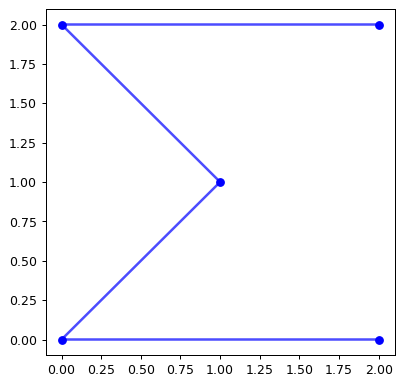

In [4]:
from shapely.plotting import plot_line

fig = plt.figure(1, figsize=(5,5), dpi=90)
ax = fig.add_subplot(111)

plot_line(line, ax=ax, add_points=True, color='b', alpha=0.7)

Similarly, we can create Points, and Polygons

In [5]:
from shapely import MultiPoint, Point

# Create a MultiPoint; the tuples here are the (x,y) coordinates for each point
multi_points = MultiPoint([(2,0), (0, 0), (1, 1), (0,2), (2,2)])

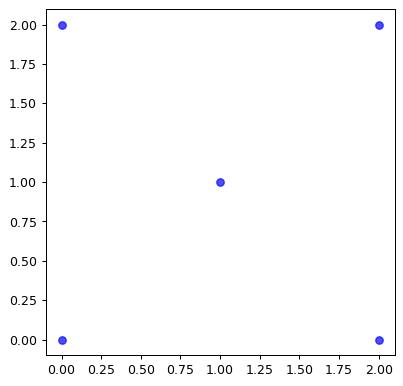

In [6]:
from shapely.plotting import plot_points

fig = plt.figure(1, figsize=(5,5), dpi=90)
ax = fig.add_subplot(111)

plot_points(multi_points, ax=ax, color='b', alpha=0.7)

In [7]:
from shapely import Polygon
polygon = Polygon([(2,0), (0, 0), (1, 1), (0,2), (2,2)])

(<matplotlib.patches.PathPatch at 0x7f31d74d2c10>,
 <matplotlib.lines.Line2D at 0x7f31d7320710>)

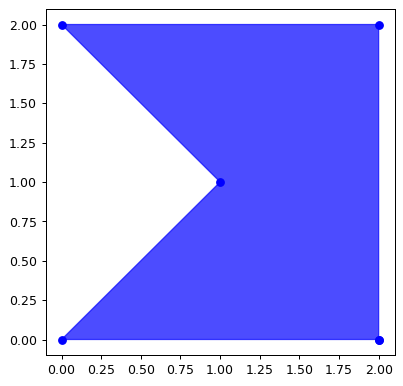

In [8]:
from shapely.plotting import plot_polygon

fig = plt.figure(1, figsize=(5,5), dpi=90)
ax = fig.add_subplot(111)

plot_polygon(polygon, ax=ax, color='b', alpha=0.7)

Shapely makes it easy to calculate properties of these shapes, e.g.

In [9]:
print('Length of line: ', line.length)
print('Area of polygon: ', polygon.area)
print('Border length of polygon: ', polygon.boundary.length)

Length of line:  6.82842712474619
Area of polygon:  3.0
Border length of polygon:  8.82842712474619


We will not cover Shapely in-depth in this tutorial, so check out the Shapely documentation for more

# Geopandas dataframes

A geopandas dataframe is just like a pandas dataframe, except one or more columns contain Shapely geometries.

In [10]:
import geopandas as gpd
from geodatasets import get_path

path_to_data = get_path("nybb")
gdf = gpd.read_file(path_to_data)


gdf.head()

ERROR 1: PROJ: proj_create_from_database: /opt/jaspy/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 4 whereas a number >= 6 is expected. It comes from another PROJ installation.


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In this case, the geometry column contains `MultiPolygon`s, which are collections of one or more `Polygon` object (in this case each one provides the outline of a New York borough)

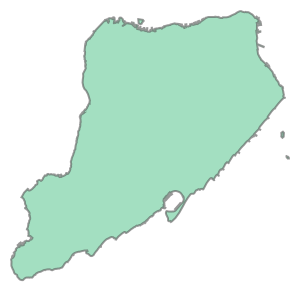

In [11]:
gdf['geometry'].iloc[0]

Each object in the geometry column is a Shapely object


In [12]:
type(gdf['geometry'].iloc[0])

shapely.geometry.multipolygon.MultiPolygon

Lets set the index to the Borough Name to make selection of data easier


In [13]:
gdf = gdf.set_index('BoroName')

We can easily calculate properties of each borough using geopandas. For example, lets calculate the area of each borough (applies to the default geometry; in this case there is only one)


In [14]:
print(gdf.area)
print('\n')

BoroName
Staten Island    1.623822e+09
Queens           3.045214e+09
Brooklyn         1.937478e+09
Manhattan        6.364712e+08
Bronx            1.186926e+09
dtype: float64




Lets select Staten Island and explore its properties

In [15]:
staten_island_geom = gdf.loc['Staten Island','geometry']

Just as with Shapely, we can easily calculate the area of this `MultiPolygon`

In [16]:
staten_island_geom.area

1623821996.7068334

The boundary of this `MultiPolygon` is a `MultiLineString` (i.e. a collection of many lines)


<class 'shapely.geometry.multilinestring.MultiLineString'>


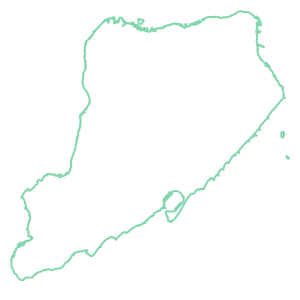

In [17]:
print(type(staten_island_geom.boundary))
staten_island_geom.boundary

Calculate the central point of the Borough

In [18]:
print(staten_island_geom.centroid)

POINT (941639.4503875391 150931.99114112832)


These methods can also be applied at the dataframe level
e.g., let's create a centroid column

In [19]:
gdf['centroid'] = gdf.centroid

Now Let's calculate the distance of all borough centroids to Staten Island

In [20]:
si_distance = gdf["centroid"].distance(gdf.loc['Staten Island','centroid'])
si_distance

BoroName
Staten Island         0.000000
Queens           103781.535276
Brooklyn          61674.893421
Manhattan         88247.742789
Bronx            126996.283623
dtype: float64

## Plotting

Plotting data can be done similarly to in Pandas; you can specify a data column to determine the colour scheme

<Axes: >

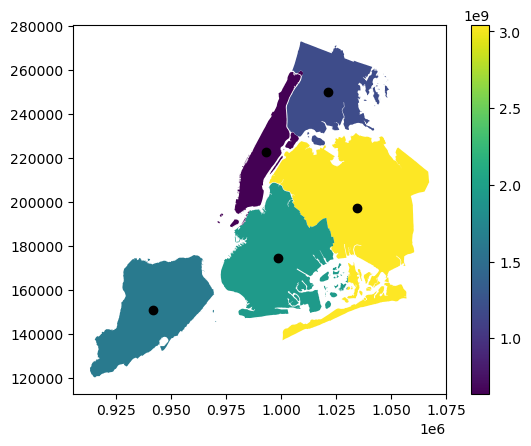

In [21]:
# Plot boroughs, with colour scheme determined by borough area
ax = gdf.plot(gdf.area, legend=True)

# Plot centroids as well
gdf["centroid"].plot(ax=ax, color="black")

### Coordinate Reference System

Each geodataframe comes with a Coordinate Reference System. In this case, it is in feet

Inspect the Coordinate Reference System using .crs

In [22]:
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Lets convert this to Lat/Lon instead

<Axes: >

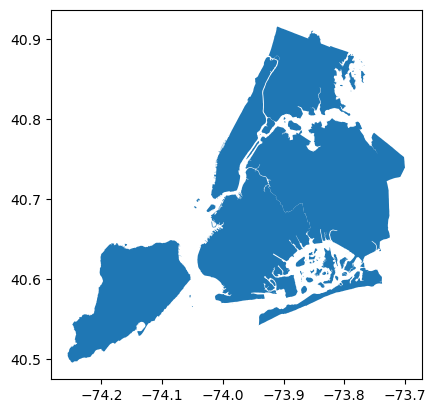

In [23]:
gdf = gdf.set_geometry("geometry")
boroughs_latlon = gdf.to_crs("EPSG:4326")
boroughs_latlon.plot()

### Note: 
for operations involving distances, you must project to a coordinate reference system that is expressed in terms of distance units (m, feet, etc) rather than degrees

There are many different projections, and picking the right coordinate reference system is not easy, as each one will be a different projection of the earth onto a flat surface. To make this projection, the relationship between different points can be distorted. 

# Aggregations

<Axes: >

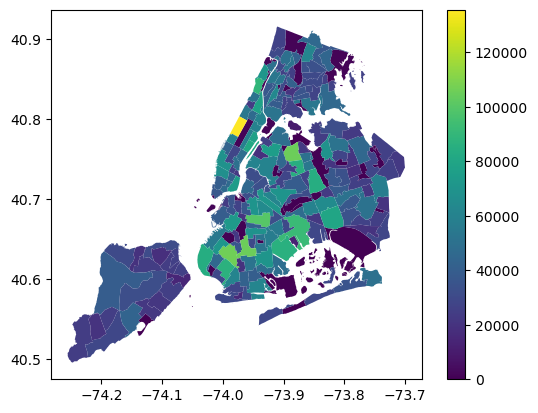

In [24]:
# Let's load a more granular version of the NYC data, broken down into neighbourhoods
path_to_data = get_path("geoda.nyc_neighborhoods")
neighbourhood_gdf = gpd.read_file(path_to_data)

neighbourhood_gdf.head()
neighbourhood_gdf.plot('poptot', legend=True)

<Axes: >

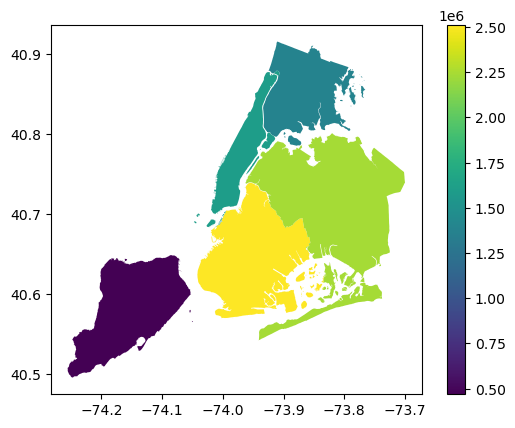

In [25]:
# Now lets aggregate the population by Borough
# Note that geometry must be included in the columns otherwise it's just a pandas dataframe!

# We use the poptot variable, which is the total population for each neighbourhood
# The dissolve function here is the equivalent of groupby for pandas; we are 'dissolving' nieghbourhoods into boroughs.
agg_gdf = neighbourhood_gdf[['boroname', 'poptot', 'geometry']].dissolve(by='boroname', aggfunc='sum')
agg_gdf.plot('poptot', legend=True)

## Joining data

`GeoDataFrame`s can be joined in very intuitive ways, similarly to how pandas dataframes are joined

Let's load two datasets, one of large rivers, and the other with country boundaries 
(Country boundaries taken from https://www.naturalearthdata.com/)

In [26]:
lakes_gdf = gpd.read_file(os.path.join(data_dir, 'ne_10m_lakes.zip'))
country_gdf = gpd.read_file(os.path.join(data_dir, 'ne_110m_admin_0_countries.zip'))

Lets select the shape corresponding to Germany

In [27]:
gpd.read_file(get_path('eea large rivers')).crs

<Projected CRS: PROJCS["ETRS_1989_LAEA_52N_10E",GEOGCS["ETRS89",DA ...>
Name: ETRS_1989_LAEA_52N_10E
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Azimuthal Equal Area
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [28]:
german_df = country_gdf[(country_gdf['SOVEREIGNT'] == 'Germany')]

Geopandas has a special spatial join operation, which allows us to join data based on their relative spatial properties

For example, in this case we will find all rivers that lie within the USA boundary

First we must ensure that both dataframes have the same CRS; in this case they don't, so lets convert the rivers to EPSG:4326

In [29]:
lakes_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
country_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
german_df = german_df.to_crs(lakes_gdf.crs)

Now perform the spatial join operation. The predicate argument controls how we should match them, here we just look for rivers that pass through Germany, but aren't completely contained

<Axes: >

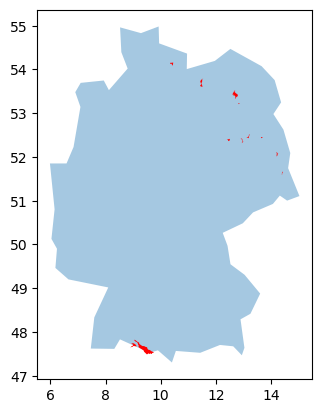

In [32]:
from geopandas.tools import sjoin

german_lakes = sjoin(lakes_gdf, german_df, how='inner', predicate='intersects')
ax = german_df.plot(alpha=0.4)
german_lakes.plot(ax=ax, color='r')


Note that we used the 'intersects' predicate, so it includes lake Bodensee that also sits in Switzerland and Austria. There are several other predicates that are allowed:

{'crosses', 'touches', 'dwithin', 'overlaps', 'covers', 'covered_by', 'within', 'contains', 'intersects', 'contains_properly'}

If instead we used the 'covered_by' predicate, it would only return those that are completely inside the border

The predicate definition can be seen in the shapely documentation, so it is worth checking which one fits your use case. For example, a Line and Polygon have zero overlap, because of their different dimensions - intersects is more appropriate in this case.

<Axes: >

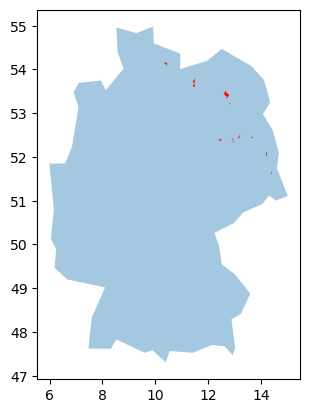

In [33]:
german_lakes = sjoin(lakes_gdf, german_df, how='inner', predicate='covered_by')
ax = german_df.plot(alpha=0.4)
german_lakes.plot(ax=ax, color='r')

To allow a bit of leeway in the join, there is also the `sjoin_nearest` method, which allows you to specify a `max_distance` parameter

## Loading Geopandas dataframes

A common format to store geopandas data in is called geoparquet

Good overview of rationale behind geoparquet https://getindata.com/blog/introducing-geoparquet-data-format/

In [34]:
# Lets save our geopandas dataframe as geoparquet
neighbourhood_gdf.to_parquet('../../data_samples/geopandas/test.geoparquet')

In [35]:
# Then we can just use read_parquet to load the data
parquet_gdf = gpd.read_parquet('../../data_samples/geopandas/test.geoparquet')

Alternatively, geopandas data is often provided as a zipped folder containing many different files, including a .shp file. Load this by using read_file and specifying the path to the .zip file 

e.g. gpd.read_file(PATH_TO_ZIP_FILE)

If the .zip file has been unpacked, then instead provide the path to the .shp file inside the folder


In [36]:
# gdf.to_file('/path/to/zip/file/file.zip')

## Exercises

1. Read ne_50m_rivers_lake_centerlines.zip from the data_samples folder. What kind of geometries does it describe? Plot some of the data to see what it looks like. Filter out the features to only include rivers.
2. Read ne_110m_admin_0_countries.zip from the data samples folder. Limit the data to the USA only (excluding countries listed as dependencies)
3. Use sjoin to create a dataframe of all rivers that intersect with the USA (let's call it usa_rivers_gdf)
4. Plot these rivers, with the USA country outline.
4. Change the coordinate reference system of usa_rivers_gdf to ESRI:102005
5. Calculate the length of each river in usa_rivers_gdf, assign it to a new column
6. Sort the dataframe by river length to get the top 10 rivers.
7. Is this the order you would expect? If not, can you think of any reasons it isn't?